# CS 480/680 assignment 4

Tips:
- Please save a copy of this notebook to avoid losing your changes.
- Debug your code and ensure that it can run.
- Save the output of each cell. Failure to do so may result in your coding questions not being graded.
- To accelerate the training time, you can choose 'Runtime' -> 'Change runtime type' -> 'Hardware accelerator' and set 'Hardware accelerator' to 'GPU'.
- Your grade is independent of the accuracy of your models. Your grade will depend on the correctness of your code and implementation.

Tips for submission:
- Do not change the order of the problems.
- Select 'Runtime' -> 'Run all' to run all cells and generate a final "gradable" version of your notebook and save your ipynb file.
- Also use 'File' -> 'Print' and then print your report from your browser into a PDF file.

##Question1 - Adversarial Training (55 points)

In this assignment, you are supposed to train a model using limited data that, in addition to generalization, also possesses good robustness.


You can add any extra libraries that you need in this cell.

In [1]:
!pip install umap-learn[plot]
!pip install cleverhans

In [2]:
import torch
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.models as models
from umap import UMAP, plot
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import random
import cleverhans
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from copy import deepcopy

/usr/local/lib/python3.10/dist-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [3]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

###Q1.1 Load Data (5 points)

In this question, you are going to use CIFAR-10 dataset. First, load this dataset, then split 20% of the data for training and the rest for validation. Make sure to maintain class balance during the split.

In [4]:
Train_SIZE = 0.2
BATCH_SIZE = 16
cifar_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
class Cifar10Dataset(torch.utils.data.Dataset):

    def __init__(self,dataset,idx,transforms=None):
        self.idx = idx
        self.transforms = transforms
        self.data = torch.utils.data.Subset(dataset, idx)

    def __getitem__(self,index):
        image,label = self.data[index]
        if(self.transforms!= None):
            image = self.transforms(image)

        return image,label

    def __len__(self):
        return len(self.data)

#Split data and create the dataloader

valid_idx, train_idx = train_test_split(np.arange(len(cifar_trainset)), test_size=Train_SIZE, shuffle=True, stratify=cifar_trainset.targets)

trainset = Cifar10Dataset(cifar_trainset, train_idx, cifar_transforms)
validset = Cifar10Dataset(cifar_trainset, valid_idx, cifar_transforms)
testset = Cifar10Dataset(cifar_testset, range(len(cifar_testset)), cifar_transforms)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

###Q1.2 Train Model (15 points)

Train a ResNet18 model using the cross-entropy loss function, and report its accuracy on validation and test datasets.

After that, reduce the dimensionality of the output of the backbone of the network and visualize it for the unseen data. You can use UMAP for dimensionality reduction. Note that for this task, you are not allowed to use the labels.

In [6]:
class Resnet18(nn.Module):
    def __init__(self, num_classes,normalize = False):
        super().__init__()
        resnet = models.resnet18(pretrained=False, num_classes=num_classes).to(device)
        self.backbone = nn.Sequential(*list(resnet.children()))[:-2]
        self.pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(resnet.fc.in_features, num_classes).to(device)

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

In [7]:
def train(model,data_loader,criterion,optimizer,attack = False):
    train_running_loss = 0
    train_running_correct = 0
    counter = 0

    model.train()

    with tqdm(data_loader, desc ="   train") as train_tqdm:
      for batch_idx, (inputs, targets) in enumerate(train_tqdm):
        model.train()
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = model(inputs).to(device)
        loss = criterion(outputs, targets)
        counter += 1

        _, pred = torch.max(outputs, 1)
        train_running_correct += (pred == targets.data).sum().item()

        loss.backward()
        train_running_loss += loss.item()
        optimizer.step()

      average_train_loss = train_running_loss / counter
      accuracy = train_running_correct / len(data_loader.dataset)

    return average_train_loss, accuracy


In [8]:
def test(model,data_loader,criterion,optimizer,attack=False):
    model.eval()
    test_running_loss = 0
    test_running_correct = 0
    counter = 0

    with tqdm(data_loader, desc ="   test") as test_tqdm:
        for batch_idx, (inputs, targets) in enumerate(test_tqdm):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs).to(device)
            loss = criterion(outputs, targets)
            test_running_loss += loss.item()
            counter += 1

            _, pred = torch.max(outputs, 1)
            test_running_correct += (pred == targets.data).sum().item()

    average_test_loss = test_running_loss / counter
    accuracy = test_running_correct / len(data_loader.dataset)

    return average_test_loss, accuracy

In [10]:
model = Resnet18(10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 10

for epoch in range(epochs):
    train_loss, train_acc = train(model,trainloader,criterion,optimizer)
    valid_loss, valid_acc = test(model,validloader,criterion,optimizer)
    print(f"Epoch {epoch+1} of {epochs}. Training loss: {train_loss:.3f}, training acc: {train_acc:.3f}, Validation Loss: {valid_loss:.3f}, Validation Accuracy: {valid_acc:.3f}")

test_loss, test_acc = test(model,testloader,criterion,optimizer)
print(f"Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}")


   test: 100%|██████████| 2500/2500 [00:13<00:00, 187.97it/s]


Epoch 1 of 10. Training loss: 2.158, training acc: 0.253, Validation Loss: 1.776, Validation Accuracy: 0.354


   test: 100%|██████████| 2500/2500 [00:13<00:00, 188.66it/s]


Epoch 2 of 10. Training loss: 1.734, training acc: 0.355, Validation Loss: 1.638, Validation Accuracy: 0.384


   test: 100%|██████████| 2500/2500 [00:13<00:00, 187.70it/s]


Epoch 3 of 10. Training loss: 1.595, training acc: 0.415, Validation Loss: 1.592, Validation Accuracy: 0.419


   test: 100%|██████████| 2500/2500 [00:13<00:00, 185.79it/s]


Epoch 4 of 10. Training loss: 1.464, training acc: 0.470, Validation Loss: 1.514, Validation Accuracy: 0.464


   test: 100%|██████████| 2500/2500 [00:13<00:00, 187.30it/s]


Epoch 5 of 10. Training loss: 1.367, training acc: 0.511, Validation Loss: 1.382, Validation Accuracy: 0.500


   test: 100%|██████████| 2500/2500 [00:13<00:00, 188.69it/s]


Epoch 6 of 10. Training loss: 1.288, training acc: 0.544, Validation Loss: 1.405, Validation Accuracy: 0.493


   test: 100%|██████████| 2500/2500 [00:13<00:00, 186.07it/s]


Epoch 7 of 10. Training loss: 1.193, training acc: 0.578, Validation Loss: 1.238, Validation Accuracy: 0.558


   test: 100%|██████████| 2500/2500 [00:13<00:00, 188.73it/s]


Epoch 8 of 10. Training loss: 1.109, training acc: 0.608, Validation Loss: 1.192, Validation Accuracy: 0.583


   test: 100%|██████████| 2500/2500 [00:13<00:00, 188.82it/s]


Epoch 9 of 10. Training loss: 0.997, training acc: 0.648, Validation Loss: 1.153, Validation Accuracy: 0.600


   test: 100%|██████████| 2500/2500 [00:13<00:00, 187.43it/s]


Epoch 10 of 10. Training loss: 0.900, training acc: 0.688, Validation Loss: 1.193, Validation Accuracy: 0.587


   test: 100%|██████████| 625/625 [00:03<00:00, 180.68it/s]

Test Loss: 1.185, Test Accuracy: 0.591


In [11]:
def gen_features(loader, model):
    features = []
    labels = []

    model.eval()
    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            outputs = model.backbone(inputs)
            outputs = outputs.view(outputs.size(0), -1).to(device)
            features.extend(outputs.cpu().numpy())
            labels.extend(targets.numpy())

    return np.array(features), np.array(labels)

In [12]:
def plot_umap(features,y):
    embedding  = UMAP().fit_transform(features)
    plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s = 1,
    c = y,
    cmap='Set3',
    )
    plt.colorbar(label='Class')
    plt.show()

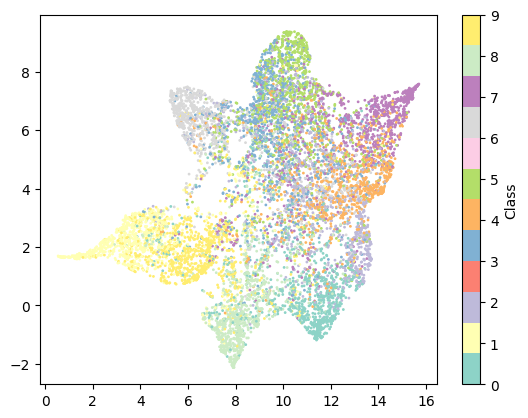

In [13]:
features, y = gen_features(testloader, model)
plot_umap(features,y)

###Q1.3 Adversarial Test (15 points)


In this section, you are required to change the unseen data before calculating the accuracy of them from the output image of the backbone. Compare the results with the previous section. Your changes should include data augmentations such as adding Gaussian noise, color jitter, etc. Additionally, you should apply an adversarial attack such as fast gradient method on the network. You can use the cleverhans library for this purpose.

In [14]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

aug_transform=transforms.Compose([
    transforms.ColorJitter(1, 1, 1, 0.1),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.1),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [15]:
def generate_fgm_examples(model,data_loader,criterion):
    model.eval()
    examples,labels = [], []
    with tqdm(data_loader) as test_tqdm:
        for batch_idx, (inputs, targets) in enumerate(test_tqdm):
            inputs, targets = inputs.to(device), targets.to(device)
            x_fgm = fast_gradient_method(model, inputs, 0.1, np.inf, targeted=False)
            y_fgm = model(x_fgm)
            loss = criterion(y_fgm, targets)
            test_tqdm.set_postfix(loss=loss.item())
            examples.append(x_fgm.detach().cpu())
            labels.append(targets.detach().cpu())

    return examples,labels

In [16]:
aug_testset = Cifar10Dataset(cifar_testset, range(len(cifar_testset)), aug_transform)
aug_test_loader = torch.utils.data.DataLoader(aug_testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
advx_test, advy_test = generate_fgm_examples(model, aug_test_loader, criterion)

adv_test_dataset = torch.utils.data.TensorDataset(torch.cat(advx_test), torch.cat(advy_test))
adv_test_loader = torch.utils.data.DataLoader(adv_test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loss, test_acc = test(model,adv_test_loader,criterion,optimizer)
print(f"Test loss: {test_loss:.3f}, test acc: {test_acc:.3f}")

   test: 100%|██████████| 625/625 [00:02<00:00, 236.20it/s]

Test loss: 3.971, test acc: 0.165


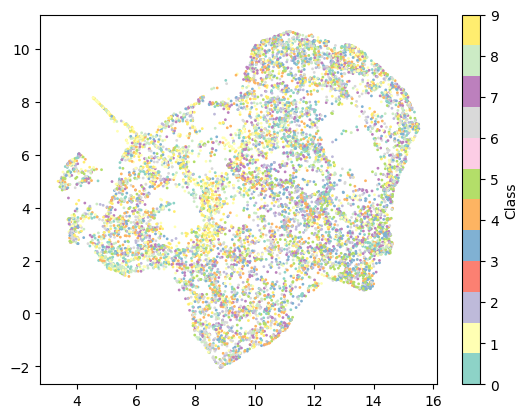

In [17]:
features, _ = gen_features(adv_test_loader, model)
plot_umap(features,advy_test)

##Q1.4 Adversarial Train (20 points)


In this section, you should repeat the experiments on parts two and three using adversarial examples and compare the results. Here, the training data will be modified using augmentations and adversarial attack.

In [18]:
#Train resnet18 using the adversarial examples
aug_trainset = Cifar10Dataset(cifar_trainset, train_idx, aug_transform)
aug_validset = Cifar10Dataset(cifar_trainset, valid_idx, aug_transform)
aug_train_loader = torch.utils.data.DataLoader(aug_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
aug_valid_loader = torch.utils.data.DataLoader(aug_validset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

advx_train, advy_train = generate_fgm_examples(model, aug_train_loader, criterion)
advx_valid, advy_valid= generate_fgm_examples(model, aug_valid_loader, criterion)

adv_train_dataset = torch.utils.data.TensorDataset(torch.cat(advx_train).cpu(), torch.cat(advy_train).cpu())
adv_valid_dataset = torch.utils.data.TensorDataset(torch.cat(advx_valid).cpu(), torch.cat(advy_valid).cpu())

adv_train_loader = torch.utils.data.DataLoader(adv_train_dataset, batch_size=BATCH_SIZE, shuffle=False)
adv_valid_loader = torch.utils.data.DataLoader(adv_valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 2500/2500 [00:50<00:00, 49.04it/s, loss=5.71]


In [20]:
#Train a new resnet18 using the adversarial examples
epochs = 10
adv_model = Resnet18(10).to(device)
adv_optimizer = torch.optim.Adam(adv_model.parameters(), lr=0.01)

for epoch in range(epochs):
    train_loss, train_acc = train(adv_model,adv_train_loader,criterion,adv_optimizer)
    valid_loss, valid_acc = test(adv_model,adv_valid_loader,criterion,optimizer)
    print(f"Epoch {epoch+1} of {epochs}. Training loss: {train_loss:.3f}, training acc: {train_acc:.3f}, Validation Loss: {valid_loss:.3f}, Validation Accuracy: {valid_acc:.3f}")


   test: 100%|██████████| 2500/2500 [00:10<00:00, 242.31it/s]


Epoch 1 of 10. Training loss: 2.501, training acc: 0.128, Validation Loss: 2.250, Validation Accuracy: 0.153


   test: 100%|██████████| 2500/2500 [00:10<00:00, 242.59it/s]


Epoch 2 of 10. Training loss: 2.198, training acc: 0.159, Validation Loss: 2.161, Validation Accuracy: 0.174


   test: 100%|██████████| 2500/2500 [00:10<00:00, 241.92it/s]


Epoch 3 of 10. Training loss: 2.148, training acc: 0.178, Validation Loss: 2.071, Validation Accuracy: 0.218


   test: 100%|██████████| 2500/2500 [00:10<00:00, 240.86it/s]


Epoch 4 of 10. Training loss: 2.100, training acc: 0.200, Validation Loss: 2.025, Validation Accuracy: 0.237


   test: 100%|██████████| 2500/2500 [00:10<00:00, 242.23it/s]


Epoch 5 of 10. Training loss: 2.054, training acc: 0.225, Validation Loss: 2.006, Validation Accuracy: 0.254


   test: 100%|██████████| 2500/2500 [00:10<00:00, 242.08it/s]


Epoch 6 of 10. Training loss: 2.010, training acc: 0.245, Validation Loss: 1.997, Validation Accuracy: 0.266


   test: 100%|██████████| 2500/2500 [00:10<00:00, 241.48it/s]


Epoch 7 of 10. Training loss: 1.973, training acc: 0.266, Validation Loss: 1.949, Validation Accuracy: 0.275


   test: 100%|██████████| 2500/2500 [00:10<00:00, 241.35it/s]


Epoch 8 of 10. Training loss: 1.938, training acc: 0.282, Validation Loss: 1.943, Validation Accuracy: 0.286


   test: 100%|██████████| 2500/2500 [00:10<00:00, 241.99it/s]


Epoch 9 of 10. Training loss: 1.885, training acc: 0.302, Validation Loss: 1.949, Validation Accuracy: 0.294


   test: 100%|██████████| 2500/2500 [00:10<00:00, 241.92it/s]

Epoch 10 of 10. Training loss: 1.834, training acc: 0.325, Validation Loss: 1.903, Validation Accuracy: 0.301


In [21]:
test_loss, test_acc = train(adv_model,adv_test_loader,criterion,optimizer)
print(f"Test loss: {test_loss:.3f}, test acc: {test_acc:.3f}")

   train: 100%|██████████| 625/625 [00:06<00:00, 93.71it/s]

Test loss: 1.944, test acc: 0.298


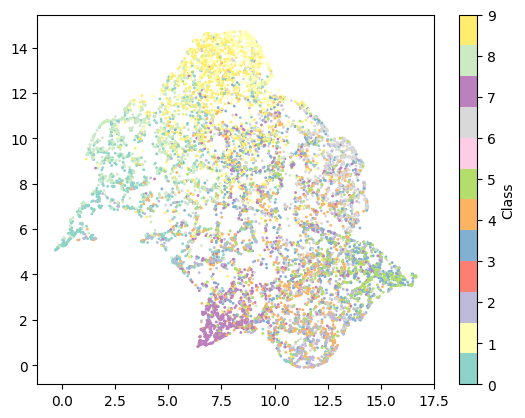

In [22]:
features, y_test = gen_features(testloader, adv_model)
plot_umap(features,y_test)

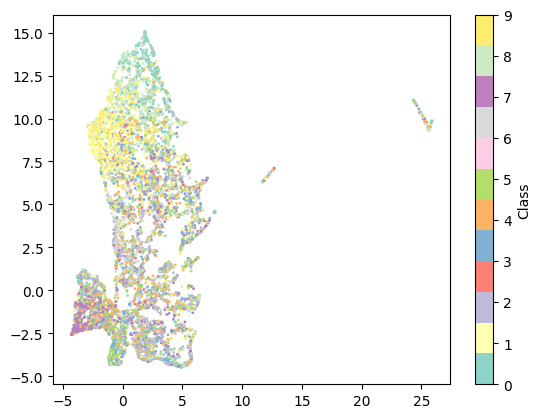

In [23]:
features, advy_test = gen_features(adv_test_loader, adv_model)
plot_umap(features,advy_test)

##Question2 - Diffusion Model (45 points)

This homework helps you implement a Denoising Diffusion Probabilistic Model (DDPM).  



You can add any extra libraries that you need in this cell.

In [ ]:
!pip install diffusers

In [54]:
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import torch.nn as nn
from matplotlib import pyplot as plt
from PIL import Image
from keras.datasets import cifar10
from diffusers import UNet2DModel, DDPMScheduler
import math
import gc
from torch.optim.lr_scheduler import StepLR

###Q2.1 Load Data (5 points)

In this question, you are going to use one arbitrary class of CIFAR-10 dataset. First, load this dataset, then choose any class you want and use that for the rest of this question.

In [122]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [123]:
class CustomDataset(Dataset):
    def __init__(self, images, transform=None):
        self.transform = transform
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image, label = self.images[idx]
        if(self.transform):
          image = self.transform(image)
        return image


preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
car_index = cifar_trainset.class_to_idx['automobile']
idx = [i for i, (images, label) in enumerate(cifar_trainset) if label == car_index]
car_subset = torch.utils.data.Subset(cifar_trainset, idx)
dataloader = DataLoader(CustomDataset(images=car_subset, transform=preprocess), batch_size=8, shuffle=True)

Files already downloaded and verified


In [124]:
def show_images(x):
    x = x * 0.5 + 0.5
    grid = torchvision.utils.make_grid(x)
    grid = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid = Image.fromarray(np.array(grid).astype(np.uint8))
    return grid

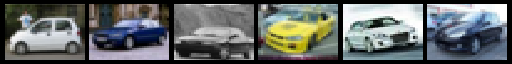

In [125]:
x_test = next(iter(dataloader))[:6]
show_images(x_test).resize((8 * 64, 64), resample=Image.NEAREST)

###Q2.2 Forward pass (10 points)

In this section, you are going to implement the forward pass of your diffusion model. You can use diffusers library for this task. Then use show_images function to plot your target image at different times of the forward pass. (Simply use the default hypermeters mentioned in the DDPM paper or the default values of the diffuser library. Visualising images every 100 steps is enough)

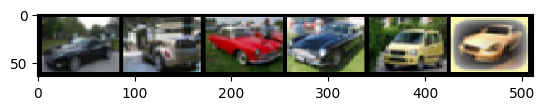

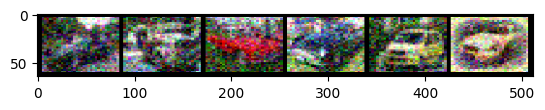

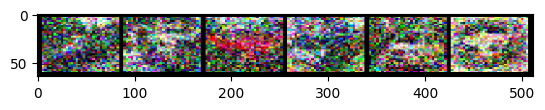

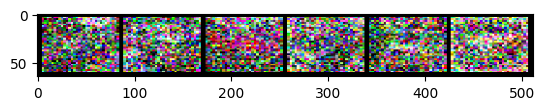

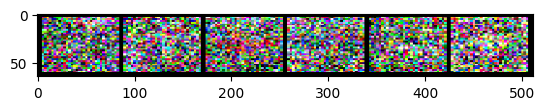

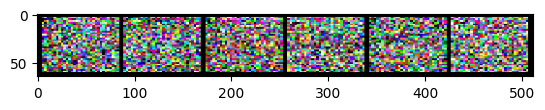

In [126]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
def forward_pass(images):
    res = [None for i in range(len(images))]
    for i in range(len(images)):
        noise = torch.randn(images.shape).to(device)
        timesteps = torch.LongTensor([i*100]).type(torch.int64).to(device)
        res[i] = noise_scheduler.add_noise(images, noise, timesteps)
    return res

imgs = next(iter(dataloader))[:6].to(device)

forward = forward_pass(imgs)

for i in forward:
    plt.imshow(show_images(i).resize((8 * 64, 64), resample=Image.NEAREST))
    plt.show()

###Q2.3 Denoising (15 points)

In this section, you will implement the denoising part of your diffusion model. First, create a U-net and train it on your CIFAR10 data. Then, start from random noise and plot the denoised images of 6 random samples. (In the DDPM paper Sec 3.3, they also trained a reverse process decoder. You are not required to implement it in this assignment. Visualizing the outputs of the diffusion network is sufficient.)

In [132]:
diff_model = UNet2DModel(
    sample_size=32,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(32, 32, 64, 128),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
 ).to(device)

In [133]:
def train(model,data_loader,criterion,optimizer):
    running_train_loss = 0
    counter = 0

    model.train()
    with tqdm(data_loader, desc ="   train") as train_tqdm:
        for batch_idx, inputs in enumerate(train_tqdm):
            model.train()
            inputs = inputs.to(device)

            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (inputs.shape[0],), dtype=torch.int64).to(device)
            noise = torch.randn(inputs.shape).to(device)
            noise_input = noise_scheduler.add_noise(inputs, noise, timesteps)
            pred = model(noise_input, timesteps)[0]

            optimizer.zero_grad()
            curr_loss = criterion(pred, noise)
            curr_loss.backward()
            optimizer.step()

            running_train_loss += curr_loss
            counter += 1
            train_tqdm.set_postfix(loss=curr_loss.item())

    return running_train_loss/counter

   train: 100%|██████████| 625/625 [00:44<00:00, 13.93it/s, loss=0.0433]


Epoch 1/10: Train Loss: 0.0775


   train: 100%|██████████| 625/625 [00:45<00:00, 13.74it/s, loss=0.0429]


Epoch 2/10: Train Loss: 0.0522


   train: 100%|██████████| 625/625 [00:46<00:00, 13.53it/s, loss=0.0319]


Epoch 3/10: Train Loss: 0.0472


   train: 100%|██████████| 625/625 [00:45<00:00, 13.71it/s, loss=0.0756]


Epoch 4/10: Train Loss: 0.0469


   train: 100%|██████████| 625/625 [00:45<00:00, 13.80it/s, loss=0.0938]


Epoch 5/10: Train Loss: 0.0444


   train: 100%|██████████| 625/625 [00:45<00:00, 13.64it/s, loss=0.0372]


Epoch 6/10: Train Loss: 0.0431


   train: 100%|██████████| 625/625 [00:46<00:00, 13.52it/s, loss=0.0444]


Epoch 7/10: Train Loss: 0.0451


   train: 100%|██████████| 625/625 [00:45<00:00, 13.65it/s, loss=0.0232]


Epoch 8/10: Train Loss: 0.0438


   train: 100%|██████████| 625/625 [00:45<00:00, 13.66it/s, loss=0.00582]


Epoch 9/10: Train Loss: 0.0439


   train: 100%|██████████| 625/625 [00:46<00:00, 13.47it/s, loss=0.039]

Epoch 10/10: Train Loss: 0.0410


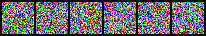

In [134]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(diff_model.parameters(), lr=0.001)
lr_scheduler = StepLR(optimizer, step_size = 10, gamma=0.1)
epochs = 10

for epoch in range(epochs):
    loss = train(diff_model, dataloader, criterion, optimizer)
    print(f"Epoch {epoch+1}/{epochs}: Train Loss: {loss:.4f}")
    lr_scheduler.step()

randomnoise = torch.randn(6, 3, 32, 32).to(device)
show_images(randomnoise)

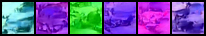

In [135]:
with torch.no_grad():
    for t in noise_scheduler.timesteps:
        result = diff_model(randomnoise, t, return_dict=False)[0]
        randomnoise = noise_scheduler.step(result, t, randomnoise).prev_sample
show_images(randomnoise)

###Q2.4 Conditional Equation (15 points)

In this part, you should express $\alpha_t$ in terms of the values of $\beta_i$, in the following equation:

$$q(z_t|z_0) = \mathcal{N}(z_t; \sqrt{\alpha_t}z_0, (1-\alpha_t)I)$$

Take this into account that the conditional variance for the one step forward diffusion (the following equation) at time t is given by $\beta_t$.

$$q(z_t|z_{t-1}) = \mathcal{N}(z_t; \sqrt{1-\beta_t}z_{t-1}, \beta_tI)$$

solution:

$z_t = \sqrt{1 - \beta_t}z_{t-1} + ϵ_tI$ where $ϵ_t \sim N(0, \beta_t)$

$z_t = \sqrt{1 - \beta_t}(\sqrt{1 - \beta_{t-1}}z_{t-2} + ϵ_{t-1}I) + ϵ_tI$ where $ϵ_t \sim N(0, \beta_t)$ and $ϵ_{t-1} \sim N(0, \beta_{t-1})$

$z_t = \sqrt{(1 - \beta_t)(1 - \beta_{t-1})}z_{t-2} + (\sqrt{1 - \beta_{t}}ϵ_{t-1} + ϵ_t)I$ where $ϵ_t \sim N(0, \beta_t)$ and $ϵ_{t-1} \sim N(0, \beta_{t-1})$

$z_t = \sqrt{(1 - \beta_t)(1 - \beta_{t-1})}z_{t-2} + (ϵ)I$ where $ϵ \sim N(0, 1 - (1-\beta_t)(1-\beta_{t-1}))$

Continuing the pattern, we have

$z_t = \sqrt{\Pi_{i=1}^t(1 - \beta_i)}z_{0} + (ϵ)I$ where $ϵ \sim N(0, 1 - \Pi_{i=1}^t(1 - \beta_i))$

Let $\alpha_t = \Pi_{i=1}^t(1 - \beta_i)$, then $z_t = \sqrt{\alpha_t}z_{0} + (ϵ)I$ where $ϵ \sim N(0, 1 - \alpha_t)$

Thus, $q(z_t|z_0) = N(z_t; \sqrt{\alpha_t}z_{0}, (1-\alpha_t)I)$ as desired.